In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/full-filled-brain-stroke-dataset/full_data.csv
/kaggle/input/full-filled-brain-stroke-dataset/full_filled_stroke_data (1).csv


In [2]:
#import potrebnih biblioteka

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
from tensorflow.keras.layers import BatchNormalization
from keras.models import Model, load_model, Sequential
from tensorflow.keras.models import Model
from keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Bidirectional, GRU, Dense,Dropout
from tensorflow.keras.optimizers import Adamax

In [3]:
#Učitavanje file-a
data=pd.read_csv('/kaggle/input/full-filled-brain-stroke-dataset/full_data.csv')

In [4]:
data


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
4976,Male,41.0,0,0,No,Private,Rural,70.15,29.8,formerly smoked,0
4977,Male,40.0,0,0,Yes,Private,Urban,191.15,31.1,smokes,0
4978,Female,45.0,1,0,Yes,Govt_job,Rural,95.02,31.8,smokes,0
4979,Male,40.0,0,0,Yes,Private,Rural,83.94,30.0,smokes,0


In [5]:
#postavljanje X i y varijable
target='stroke'
X=data.loc[:,data.columns!=target]
y=data.loc[:,data.columns==target]

In [6]:
#korištenje one_hot encoding za kategoričke varijable
columns=['gender','age','hypertension','heart_disease','ever_married','work_type',
        'Residence_type','avg_glucose_level','bmi','smoking_status']
X=pd.get_dummies(X[columns])


stroke
0    4733
1     248
Name: count, dtype: int64


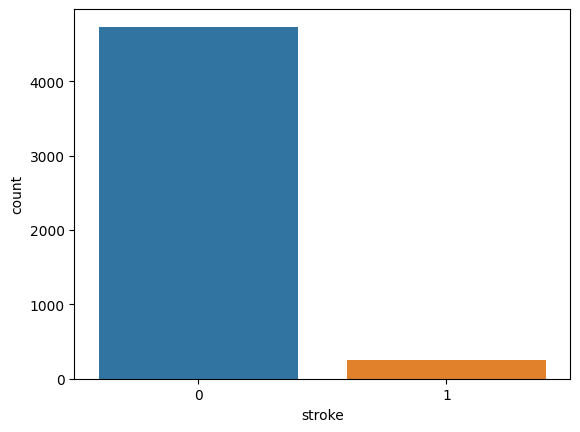

In [7]:
#prikaz target varijable na plotu
ax = sns.countplot(x=target,data=data)
print(data[target].value_counts())

In [8]:
#korištenje SMOTE() za rješavanje disbalansa između target vrijednosti
import seaborn as sns
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE

oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

stroke
1    4733
0    4733
Name: count, dtype: int64


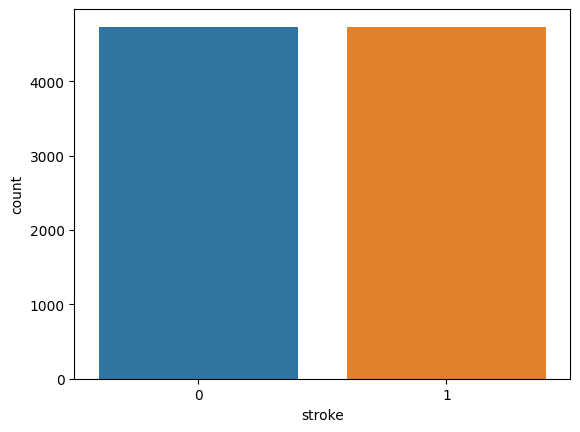

In [9]:
#prikaz nakon SMOTE()
ax=sns.countplot(x=target,data=y)
print(y[target].value_counts())

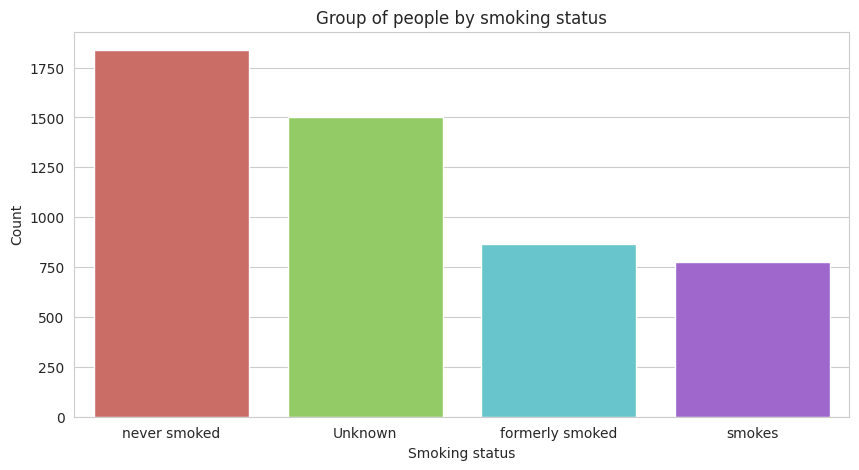

In [10]:
#vizualizacija smoking_statusa po grupama

smoking_status=data['smoking_status'].value_counts()

plt.figure(figsize=(10, 5))
sns.set_style("whitegrid")
sns.barplot(x=smoking_status.index, y=smoking_status.values, palette='hls')
plt.title('Group of people by smoking status')
plt.xlabel('Smoking status')
plt.ylabel('Count')
plt.show()

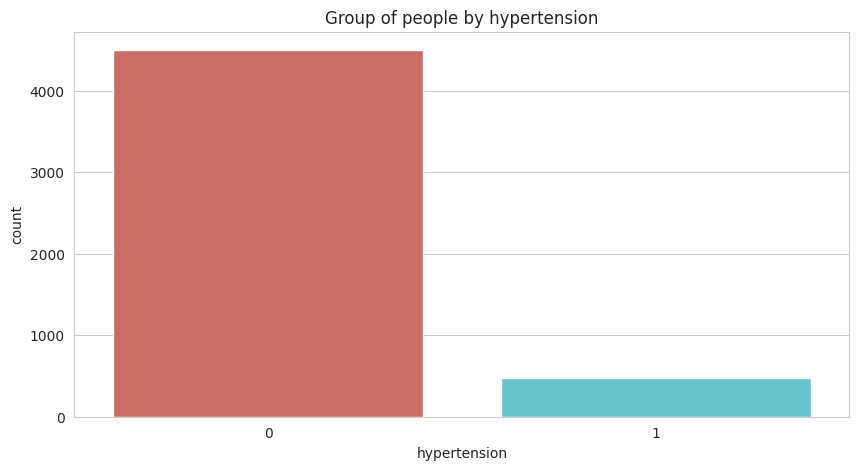

In [11]:
#vizualizacija hypertension po grupama

hypertension=data['hypertension'].value_counts()

plt.figure(figsize=(10, 5))
sns.set_style("whitegrid")
plt.title('Group of people by hypertension')
plt.xlabel('Hypertension')
plt.ylabel('Count')
sns.countplot(x="hypertension",data=data, palette='hls')
plt.show()


In [12]:
#razdvajanje podataka na trening i testne
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [13]:
#prikaz podataka
print("X train shape: ",X_train.shape)
print("X test shape: ",X_test.shape)
print("y train shape: ",y_train.shape)
print("y test shape: ",y_test.shape)

X train shape:  (7572, 19)
X test shape:  (1894, 19)
y train shape:  (7572, 1)
y test shape:  (1894, 1)


In [14]:
#incijaliziranje slojeva:input,tri skrivena sloja i output sloj
model=Sequential()
model.add(Dense(400,activation='relu',input_shape=(X_train.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(400,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

In [15]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 400)            │         8,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 400)            │       160,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        51,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 219,857 (858.82 KB)

 Trainable params: 219,857 (858.82 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
#postavljanje funkcije pogreške i optimajzera(algoritma za smanjivanje pogreške)
optimizer=Adamax(learning_rate=0.001)
model.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])

In [17]:
#treniranje modela
history=model.fit(X_train,y_train,
                 batch_size=128,
                 epochs=300,
                 validation_data=(X_test,y_test))

Epoch 1/300
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.5244 - loss: 3.0124 - val_accuracy: 0.7276 - val_loss: 0.5593
Epoch 2/300
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5676 - loss: 1.2326 - val_accuracy: 0.7450 - val_loss: 0.5707
Epoch 3/300
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5967 - loss: 0.9386 - val_accuracy: 0.6742 - val_loss: 0.5838
Epoch 4/300
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6200 - loss: 0.8625 - val_accuracy: 0.6103 - val_loss: 0.6408
Epoch 5/300
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6392 - loss: 0.7757 - val_accuracy: 0.6399 - val_loss: 0.6093
Epoch 6/300
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6495 - loss: 0.7162 - val_accuracy: 0.6663 - val_loss: 0.6098
Epoch 7/300
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6508 - loss: 0.7044 - val_accuracy: 0.6558 - val_loss: 0.6027
Epoch 8/300
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6652 - loss: 0.6666 - val_accuracy: 0.6758 -

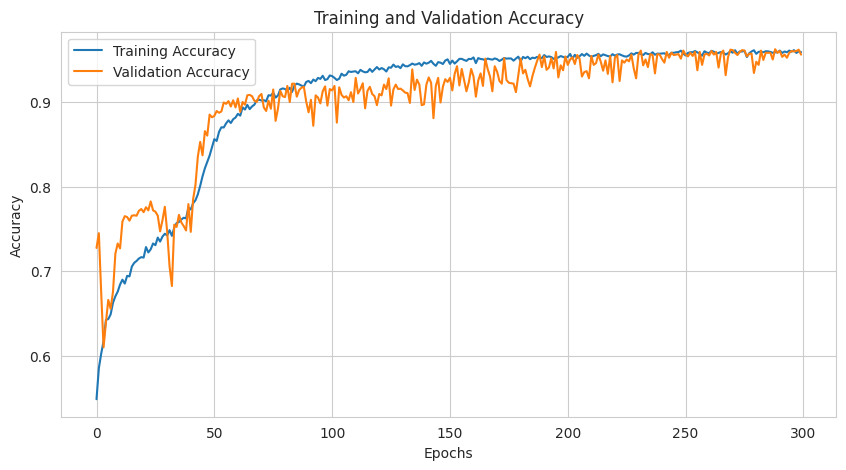

In [18]:
#prikaz training and validation acc

train_acc=history.history['accuracy']
val_acc=history.history['val_accuracy']


plt.figure(figsize=(10, 5))

plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.legend()
plt.show()

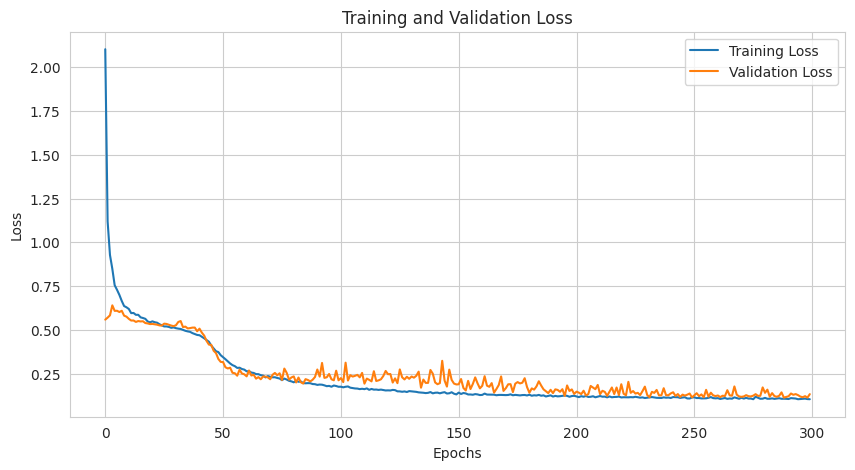

In [19]:
#prikaz training and validation loss
tr_loss=history.history['loss']
val_loss=history.history['val_loss']

plt.figure(figsize=(10, 5))


plt.plot(tr_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')


plt.legend()
plt.show()

In [20]:
#evaluacija modela na testnim podacima
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy}")
print(f"Test loss: {test_loss}")

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9535 - loss: 0.1431
Test accuracy: 0.9556494355201721
Test loss: 0.13430365920066833
